In [1]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy import fftpack
from shutil import copyfile
import time
import os
import csv

In [2]:

def readImage(image_name):
    image = cv2.imread(image_name)
    return image
##

def fft(channel):
    fft = np.fft.fft2(channel)
    fshift = np.fft.fftshift(fft)
    
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    
    magnitude_spectrum = highPassFilter(magnitude_spectrum)
    return magnitude_spectrum
##

def highPassFilter(input):
    output = np.zeros((len(input),len(input[0])))
    
    rows, cols = len(input), len(input[0])
    center_row, center_col = int(rows/2), int(cols/2)
    sigma = int(len(input)*0.04)
    
    mask_circle = np.ones((rows,cols), np.uint8)

    for i in range (center_row-sigma,center_row+sigma):
        for j in range (center_col-sigma,center_col+sigma):
            
            distance = np.sqrt((center_row - i)**2 + (center_col - j)**2)
            
            if (distance < sigma):
                mask_circle[i,j] = 0
            ##
    ##

##    a, b = center_row, center_col
##    r = sigma
##    n = r*2+1
##
##    x, y = np.ogrid[-a:n-a, -b:n-b]
##    circle = x*x + y*y <= r*r
##    circle=int(circle*255)
##    print(circle[30,30])
##    print(len(circle))
##    print(len(circle[0]))
##    mask_circle[circle]=0
    
    output= input*mask_circle
    
    return output
##

def cart2pol(input):
    
    binary = np.zeros((len(input),len(input[0])))
    binarySpect = np.zeros((len(input),len(input[0])))
    
    angle = np.zeros((360,1))
    thrsh = np.amax(input)*0.8
    
    for i in range (0,len(input)):
        for j in range (0,len(input[0])):
            if (input[i,j] > thrsh):
                binarySpect[i,j] = input[i,j]
                binary[i,j] = 1
                
    ##
    
    #Coodrinate origin
    x0 = int(len(input)/2)
    y0 = int(len(input[0])/2)
    
    for i in range (0,len(input)):
        for j in range (0,len(input[0])):
            if (binary[i,j]==1):
                ind=int(np.arctan2(y0-j,x0-i) * 180 / np.pi)+90
                #print(ind)
                angle[ind]=angle[ind]+1
    ##
    
    return angle, binarySpect
##

def meanFilterHistogram(input, kernel_size):
    output = input.copy()
    n = int(kernel_size/2)
    for i in range (kernel_size,len(input)-kernel_size):
        output[i] = (input[i-n:i+n].sum())/kernel_size 
    ##
    
    return output
##

def DEV_drawGui(original_image, fft, result_image):
    plt.subplot(131),plt.imshow(original_image, cmap = 'gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(132),plt.imshow(fft, cmap = 'gray')
    plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
    plt.subplot(133),plt.imshow(result_image, cmap = 'gray')
    plt.title('Filtered Spectrum'), plt.xticks([]), plt.yticks([])
    plt.show()
    return 1
##


In [3]:

def train_data_gen(directory):
    #directory='Dataset/ManMadeScenesTrain'
#    filename='10.ppm'    
#    image_name = filename
#    print(filename)
#    original_image = readImage(image_name)
        
#    result_array = np.zeros_like(original_image)
    
#    gray_img = cv2.cvtColor(np.array(original_image), cv2.COLOR_BGR2GRAY)
#    result_array = fft(gray_img)
#    result_image = Image.fromarray(result_array)
        
#    binary_image = Image.fromarray(cart2pol(result_array,filename))
    
#    DEV_drawGui(original_image, binary_image)
    start=time.time()
    
    for filename in os.listdir(directory):
        copyfile(directory+'/'+filename, filename)
        #filename='3.ppm'    
        image_name = filename
        print('Reading...:'+filename)
        original_image = readImage(image_name)
        
        result_array = np.zeros_like(original_image)
    
        gray_img = cv2.cvtColor(np.array(original_image), cv2.COLOR_BGR2GRAY)
        result_array = fft(gray_img)
        result_image = Image.fromarray(result_array)
        
        angles, binary_image = cart2pol(result_array)
        
        filteredAngles = meanFilterHistogram(angles,7)  
        label=np.array([1])
    #print(label.shape)
    #print(filteredAngles.T.shape)
    
        feature_print=np.concatenate((label,np.ravel(filteredAngles)))
        feature_print=feature_print.reshape((361,1))
    
        
        
        with open('features_train.csv', 'a') as csvFile:
            writer = csv.writer(csvFile,delimiter ='\t')
#        writer.writerows(map(lambda x: [x], feature_print.T))
            writer.writerows(feature_print.T)
        csvFile.close()
        
        plt.plot(angles)
        plt.show()
        plt.plot(filteredAngles)
        plt.savefig(filename+'_hist'+'.png')
        plt.show()
    
        DEV_drawGui(original_image, result_image, Image.fromarray(binary_image))
        os.remove(filename) 
    end=time.time()
    print('Execution_time: %f'%(end-start))
    return 1
##

#main()

D7H_4525.ppm


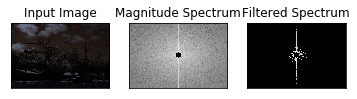

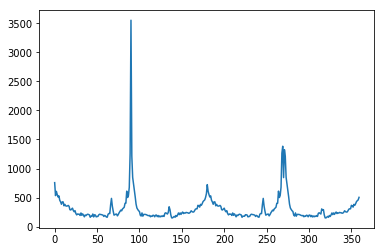

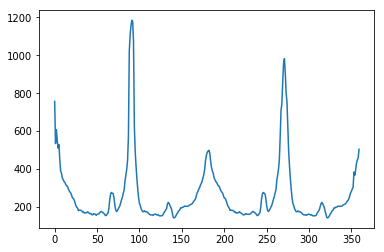

1

In [13]:
def extract_features_prediction(filename):
    #directory='Dataset/ManMadeScenesTrain' 
    image_name = filename
    print(filename)
    original_image = readImage(image_name)
        
    result_array = np.zeros_like(original_image)
    
    gray_img = cv2.cvtColor(np.array(original_image), cv2.COLOR_BGR2GRAY)
    result_array = fft(gray_img)
    result_image = Image.fromarray(result_array)
        
    angles, binary_image = cart2pol(result_array)
        
    filteredAngles = meanFilterHistogram(angles,7)  
    #label=np.array([1])
    #print(label.shape)
    #print(filteredAngles.T.shape)
    
    #feature_print=np.concatenate((label,np.ravel(filteredAngles)))
    #feature_print=feature_print.reshape((361,1))
    
    DEV_drawGui(original_image, result_image, Image.fromarray(binary_image))
    
    with open('features_test.csv', 'a') as csvFile:
        writer = csv.writer(csvFile,delimiter ='\t')
#       writer.writerows(map(lambda x: [x], feature_print.T))
        writer.writerows(filteredAngles.T)
        csvFile.close()
    
#    plt.imsave('fft.png',result_image, cmap = 'gray')
#    plt.imsave('filtered_image.png', Image.fromarray(binary_image), cmap = 'gray')
    
    plt.plot(angles)
    plt.show()
    plt.plot(filteredAngles)
    plt.savefig(filename+'_hist'+'.png')
    plt.show()
    return 1
##
#filename='D7H_4525.ppm'
#extract_features_prediction(filename)
#main()